In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func, compartment_restrainer
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import time
import os
import seaborn as sns

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Using TensorFlow backend.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
# Make up some populations (take as known)
M = 3
np.random.seed(0)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)
population_fraction = population/np.sum(population)
print (np.sum(population))

[4241. 3868. 1023.] [144101. 110004. 124468.]
378573.0


## Reference trajectory

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 7, 3)
tmat.add_transition('A', 'I', 5, 3)
tmat.add_transition('I', 'R', 14, 4)
start = np.zeros((M, C))

In [4]:
infect_fxn = maxentep.contact_infection_func(infections_compartments)
timesteps = 250
model = maxentep.MetaModel(infect_fxn, timesteps, populations=population_fraction)

In [5]:
# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# start[0,0] = 0.1
# start[0,3] = 0.01
# start[0,1] = 0.2
start[0,2] = 0.02
start[0,1] = 0.05
np.random.seed(0)
# R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = np.array([[1000, 400, 10],
             [0, 300, 300],
             [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1)
print (R_norm)
print(tmat.value)

[[0.70921986 0.66666667 0.00625   ]
 [0.         0.5        0.1875    ]
 [0.21276596 0.5        0.625     ]]
[[0.85714286 0.14285714 0.         0.        ]
 [0.         0.8        0.2        0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


In [6]:
ref_traj = model(R_norm, tmat.value, start, 0.025)[0]
print (ref_traj.shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(250, 3, 5)


In [7]:
# def f(beta, ntot, ninf):
#     p = 1 - tf.math.exp(tf.math.log(1 - tf.reshape(beta, (-1, 1)))
#                           * tf.reduce_sum((ninf) / ntot[:, :, tf.newaxis], axis=2))
#     return p
# p = []
# for i in np.linspace(0,1,10):
#     ninf = np.zeros((1,M), dtype = np.float32)
#     ninf[0,0] = i
#     print (f(0.01, np.ones((1,M), dtype = np.float32),ninf))
#     p.append(f(0.01, np.ones((1,M), dtype = np.float32),ninf))


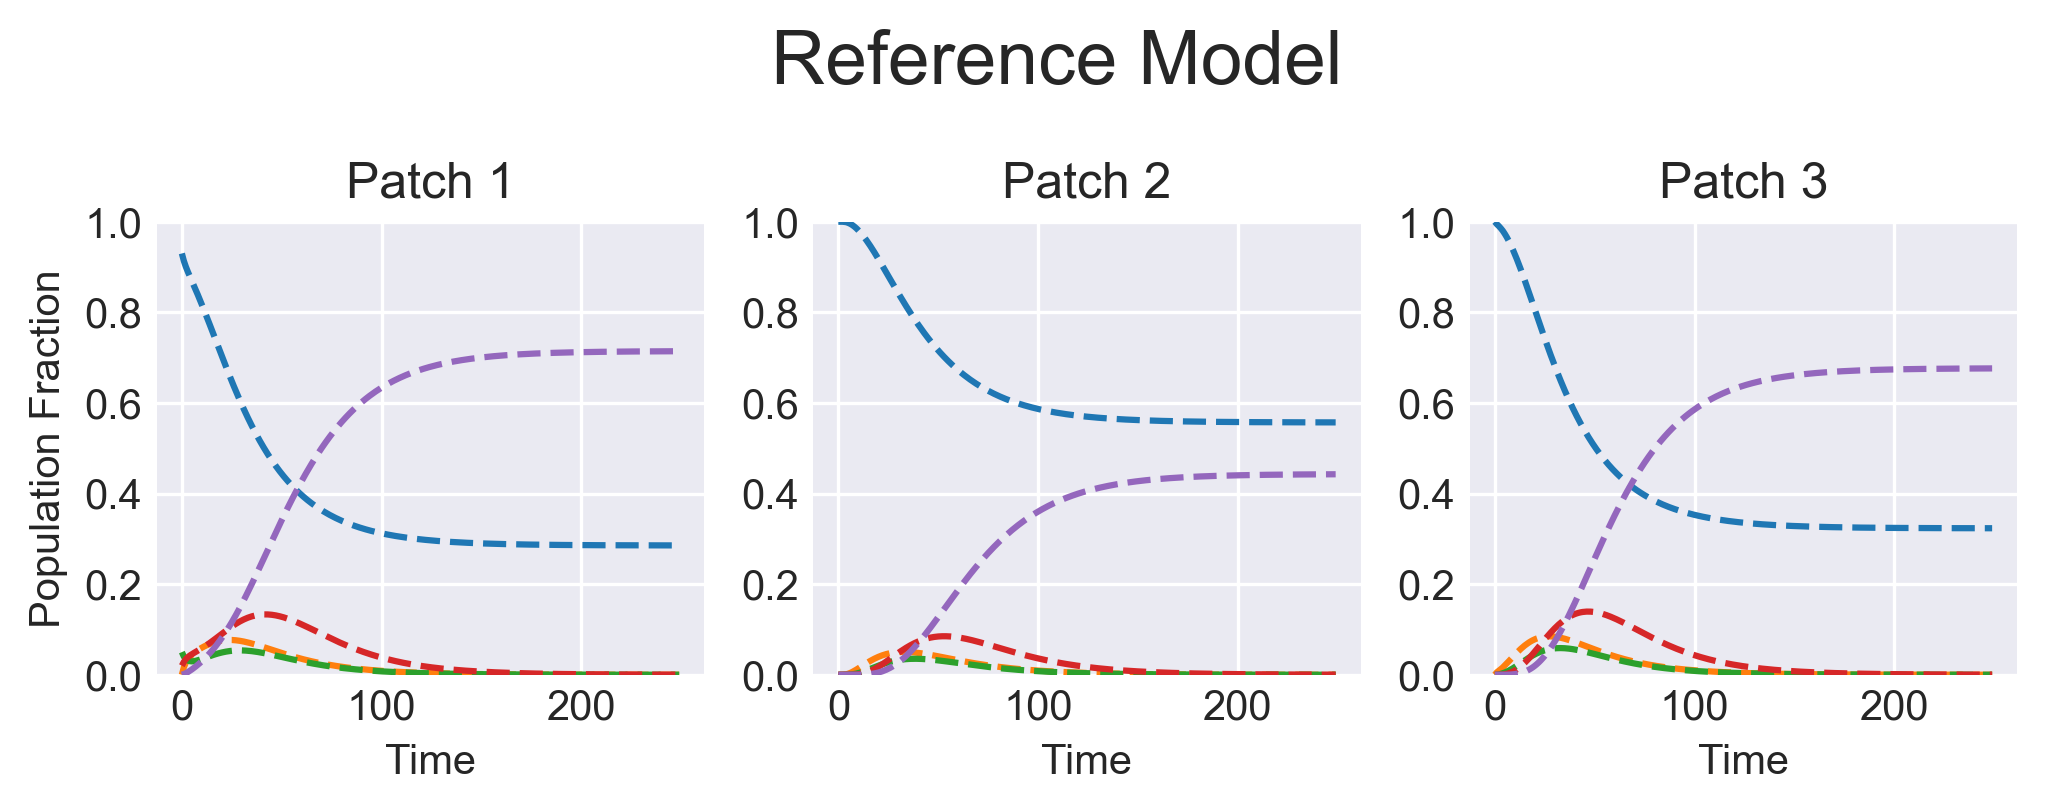

tf.Tensor(
[[9.3000001e-01 0.0000000e+00 5.0000001e-02 2.0000000e-02 0.0000000e+00]
 [9.1351068e-01 1.6489347e-02 4.0000003e-02 2.8571427e-02 1.4285714e-03]
 [9.0063554e-01 2.7008828e-02 3.4355622e-02 3.4530610e-02 3.4693875e-03]
 ...
 [2.8569031e-01 9.8567813e-05 8.5043037e-05 4.6003459e-04 7.1366608e-01]
 [2.8567964e-01 9.5171024e-05 8.2115548e-05 4.4418356e-04 7.1369892e-01]
 [2.8566933e-01 9.1897942e-05 7.9288300e-05 4.2887928e-04 7.1373063e-01]], shape=(230, 5), dtype=float32)
tf.Tensor(
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 ...
 [5.57283759e-01 1.12182679e-04 9.67724918e-05 5.21353155e-04
  4.41985935e-01]
 [5.57271600e-01 1.08315973e-04 9.34440905e-05 5.03468153e-04
  4.42023188e-01]
 [5.57259798e-01 1.04594495e-04 9.02289903e-05 4.86194942e-04
  4.42059159e-01]], shape=(230, 5),

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Reference Model', y = 1.2, fontsize = 18)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()
print (ref_traj[:-20:,0,:])
print (ref_traj[:-20:,1,:])
print (ref_traj[:-20:,1,:] == ref_traj[:-20:,0,:])
# print (tf.reduce_sum(ref_traj[:,0,:],axis=-1))

## Sample SEAIR Trajectories

Creating a set of trajectories.

In [9]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 7, 3)
tmat.add_transition('A', 'I', 5, 2)
tmat.add_transition('I', 'R', 14, 4)
full_compartments = ['S'] + compartments

In [10]:
# starting fractions probabilities
start_logits = np.zeros((M)) #anywhere
start_logits[0]=np.log(0.9)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_var = 0.9
hyper_pram.beta_start = 0.1
hyper_pram.beta_high = 0.5
hyper_pram.beta_low = 0.01
hyper_pram.start_mean = 0.001
hyper_pram.start_high = 0.001
# hyper_pram.R_var = 0.1
# hyper_pram.start_high = 0.01

In [11]:
param_model = maxentep.MetaParameterJoint(start_logits, R_norm, tmat, name='unbiased model', hypers = hyper_pram)

In [12]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 1024
batches = 4
batch_size = N*batches
outs = []
timesteps = 250
# infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
model = maxentep.MetaModel(infect_fxn, timesteps, populations=population_fraction)
for b in tqdm.tqdm(range(batches)):
    psample = param_model.sample(N)
    outs.append(model(*psample))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.96s/it]

(4096, 250, 3, 5)


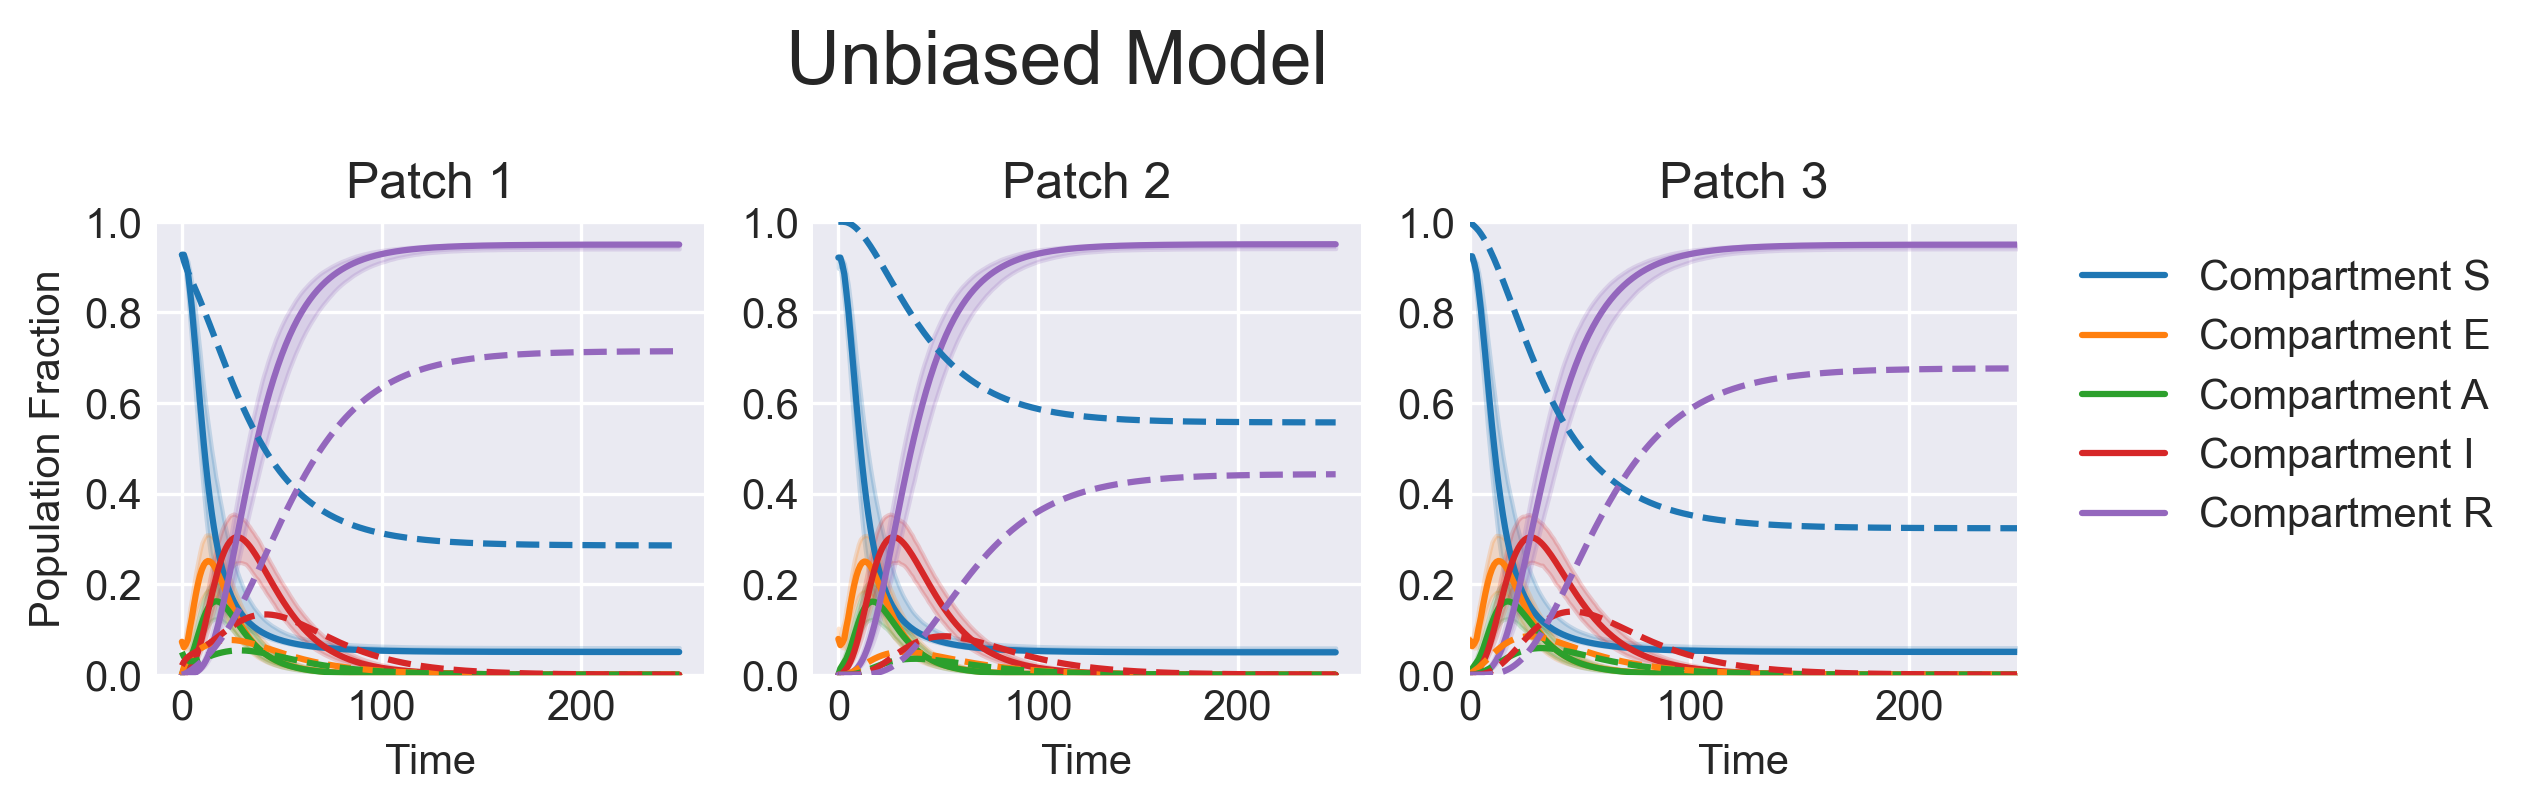

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Unbiased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_0, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_1, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_2, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()

## Make restraints from reference trajectory

In [14]:
npoints = 10
# prior = maxentep.EmptyPrior()
prior = maxentep.Laplace(0.1)
restrained_compartments = [0, 3, 4] #(infected patch)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
number_of_restrained_compartments = len(restrained_compartments) 
# restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
restrained_patches = np.array([0])
print ('Patches restrained:', restrained_patches)
print ('Total number of restraints: ', npoints*number_of_restrained_compartments*len(restrained_patches))
print ('Compartments restrained: ', restrained_compartments_names)
restraints, plot_fxns_list = maxentep.compartment_restrainer(restrained_patches, restrained_compartments, npoints, ref_traj, prior, noise=0, start_time= 0, end_time = 100)

Patches restrained: [0]
Total number of restraints:  30
Compartments restrained:  ['S', 'I', 'R']
Restraints are set on this time range: [0, 100]
59 0.40076563 0.40076562762260437
45 0.47408512 0.47408512234687805
31 0.58688277 0.5868827700614929
80 0.34004194 0.3400419354438782
17 0.7380277 0.7380276918411255
94 0.31863117 0.3186311721801758
66 0.37535176 0.37535175681114197
10 0.8168713 0.8168712854385376
52 0.43315676 0.4331567585468292
73 0.35550547 0.35550546646118164
59 0.11300838 0.11300837993621826
80 0.06942841 0.06942840665578842
38 0.13152371 0.1315237134695053
45 0.13207568 0.13207568228244781
24 0.10324775 0.1032477468252182
31 0.121692084 0.12169208377599716
17 0.08018887 0.08018887042999268
94 0.045822185 0.04582218453288078
87 0.056746352 0.05674635246396065
73 0.083592534 0.08359253406524658
31 0.16494873 0.1649487316608429
10 0.030205293 0.030205292627215385
38 0.22828968 0.2282896786928177
3 0.0066124243 0.006612424273043871
59 0.41940045 0.4194004535675049
17 0.0639

## Visualizing Restraints

Text(0, 0.5, 'Population Fraction')

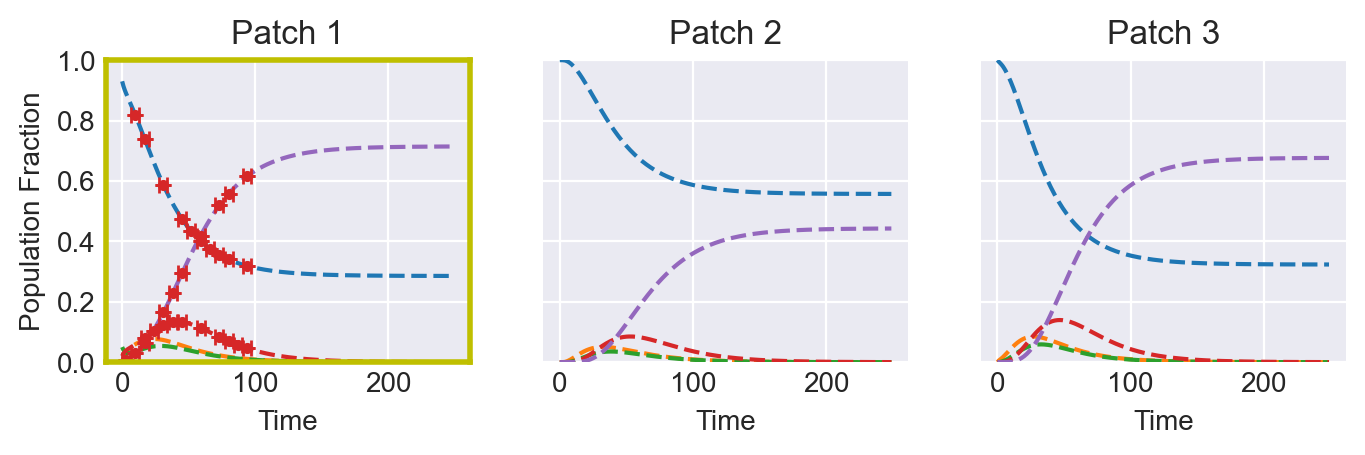

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=M, sharex=True,
                           sharey=True, figsize=(8,2), dpi =200)
for i in range(M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1),ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')


In [16]:
me_model = maxentep.MaxentModel(restraints, ref_traj=ref_traj[np.newaxis,:,:,:], trajs=trajs, population_fraction=population_fraction)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
print (ref_traj[np.newaxis,:,:,:].shape)
print (population_fraction.shape)
print (trajs.shape)

(1, 250, 3, 5)
(3,)
(4096, 250, 3, 5)


In [17]:
me_history = me_model.fit(trajs, batch_size=batch_size,epochs=1000)

Epoch 1/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0484 - ref-error-metric: 4.9501 - ref-error: 4.9501 - weight-entropy: 8.2520
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0454 - ref-error-metric: 4.9148 - ref-error: 4.9148 - weight-entropy: 8.2377
Epoch 3/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0424 - ref-error-metric: 4.8795 - ref-error: 4.8795 - weight-entropy: 8.2207
Epoch 4/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0394 - ref-error-metric: 4.9446 - ref-error: 4.9446 - weight-entropy: 8.2007
Epoch 5/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0364 - ref-error-metric: 4.8967 - ref-error: 4.8967 - weight-entropy: 8.1777
Epoch 6/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0333 - ref-error-metric: 4.9210 - ref-error: 4.9210 - weight-entropy: 8.1514
Epoch 7/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0303 - ref-error-met

1/1 [==============================] - 0s 2ms/step - loss: 5.7110e-04 - ref-error-metric: 4.5464 - ref-error: 4.5464 - weight-entropy: 7.0230
Epoch 54/1000
1/1 [==============================] - 0s 2ms/step - loss: 5.3642e-04 - ref-error-metric: 4.5170 - ref-error: 4.5170 - weight-entropy: 7.0379
Epoch 55/1000
1/1 [==============================] - 0s 2ms/step - loss: 5.0888e-04 - ref-error-metric: 4.8052 - ref-error: 4.8052 - weight-entropy: 7.0522
Epoch 56/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.8810e-04 - ref-error-metric: 4.8530 - ref-error: 4.8530 - weight-entropy: 7.0659
Epoch 57/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.7352e-04 - ref-error-metric: 5.0478 - ref-error: 5.0478 - weight-entropy: 7.0789
Epoch 58/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.6439e-04 - ref-error-metric: 4.9252 - ref-error: 4.9252 - weight-entropy: 7.0910
Epoch 59/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.598

1/1 [==============================] - 0s 3ms/step - loss: 4.3034e-04 - ref-error-metric: 4.8293 - ref-error: 4.8293 - weight-entropy: 7.1016
Epoch 106/1000
1/1 [==============================] - 0s 3ms/step - loss: 4.2949e-04 - ref-error-metric: 4.9293 - ref-error: 4.9293 - weight-entropy: 7.1027
Epoch 107/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.2867e-04 - ref-error-metric: 4.8450 - ref-error: 4.8450 - weight-entropy: 7.1038
Epoch 108/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.2789e-04 - ref-error-metric: 4.9283 - ref-error: 4.9283 - weight-entropy: 7.1049
Epoch 109/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.2715e-04 - ref-error-metric: 4.9026 - ref-error: 4.9026 - weight-entropy: 7.1060
Epoch 110/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.2645e-04 - ref-error-metric: 4.7340 - ref-error: 4.7340 - weight-entropy: 7.1070
Epoch 111/1000
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 3ms/step - loss: 3.9669e-04 - ref-error-metric: 4.8749 - ref-error: 4.8749 - weight-entropy: 7.1086
Epoch 158/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.9607e-04 - ref-error-metric: 4.6948 - ref-error: 4.6948 - weight-entropy: 7.1086
Epoch 159/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.9546e-04 - ref-error-metric: 4.9493 - ref-error: 4.9493 - weight-entropy: 7.1087
Epoch 160/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.9485e-04 - ref-error-metric: 5.0747 - ref-error: 5.0747 - weight-entropy: 7.1088
Epoch 161/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.9424e-04 - ref-error-metric: 5.1579 - ref-error: 5.1579 - weight-entropy: 7.1088
Epoch 162/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.9363e-04 - ref-error-metric: 4.9691 - ref-error: 4.9691 - weight-entropy: 7.1089
Epoch 163/1000
1/1 [==============================] - 0s 3ms/step - loss:

1/1 [==============================] - 0s 3ms/step - loss: 3.6666e-04 - ref-error-metric: 4.8831 - ref-error: 4.8831 - weight-entropy: 7.1079
Epoch 210/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.6613e-04 - ref-error-metric: 4.9934 - ref-error: 4.9934 - weight-entropy: 7.1079
Epoch 211/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.6559e-04 - ref-error-metric: 4.8805 - ref-error: 4.8805 - weight-entropy: 7.1078
Epoch 212/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.6506e-04 - ref-error-metric: 5.0710 - ref-error: 5.0710 - weight-entropy: 7.1078
Epoch 213/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.6454e-04 - ref-error-metric: 4.7901 - ref-error: 4.7901 - weight-entropy: 7.1078
Epoch 214/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.6401e-04 - ref-error-metric: 4.6189 - ref-error: 4.6189 - weight-entropy: 7.1078
Epoch 215/1000
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 3.4147e-04 - ref-error-metric: 5.0729 - ref-error: 5.0729 - weight-entropy: 7.1062
Epoch 262/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.4104e-04 - ref-error-metric: 4.8320 - ref-error: 4.8320 - weight-entropy: 7.1061
Epoch 263/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.4061e-04 - ref-error-metric: 4.7846 - ref-error: 4.7846 - weight-entropy: 7.1061
Epoch 264/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.4018e-04 - ref-error-metric: 5.1209 - ref-error: 5.1209 - weight-entropy: 7.1060
Epoch 265/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.3975e-04 - ref-error-metric: 5.1632 - ref-error: 5.1632 - weight-entropy: 7.1060
Epoch 266/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.3933e-04 - ref-error-metric: 4.9580 - ref-error: 4.9580 - weight-entropy: 7.1059
Epoch 267/1000
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 3.2150e-04 - ref-error-metric: 4.9251 - ref-error: 4.9251 - weight-entropy: 7.1037
Epoch 314/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.2116e-04 - ref-error-metric: 4.8468 - ref-error: 4.8468 - weight-entropy: 7.1037
Epoch 315/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.2083e-04 - ref-error-metric: 5.0363 - ref-error: 5.0363 - weight-entropy: 7.1036
Epoch 316/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.2050e-04 - ref-error-metric: 4.6051 - ref-error: 4.6051 - weight-entropy: 7.1036
Epoch 317/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.2016e-04 - ref-error-metric: 4.9362 - ref-error: 4.9362 - weight-entropy: 7.1035
Epoch 318/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.1984e-04 - ref-error-metric: 4.9840 - ref-error: 4.9840 - weight-entropy: 7.1035
Epoch 319/1000
1/1 [==============================] - 0s 3ms/step - loss:

1/1 [==============================] - 0s 3ms/step - loss: 3.0616e-04 - ref-error-metric: 4.8247 - ref-error: 4.8247 - weight-entropy: 7.1009
Epoch 366/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.0590e-04 - ref-error-metric: 4.5985 - ref-error: 4.5985 - weight-entropy: 7.1009
Epoch 367/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.0565e-04 - ref-error-metric: 4.9902 - ref-error: 4.9902 - weight-entropy: 7.1008
Epoch 368/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.0539e-04 - ref-error-metric: 4.5950 - ref-error: 4.5950 - weight-entropy: 7.1008
Epoch 369/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.0514e-04 - ref-error-metric: 4.9604 - ref-error: 4.9604 - weight-entropy: 7.1007
Epoch 370/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.0489e-04 - ref-error-metric: 4.7015 - ref-error: 4.7015 - weight-entropy: 7.1007
Epoch 371/1000
1/1 [==============================] - 0s 3ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 2.9445e-04 - ref-error-metric: 4.8229 - ref-error: 4.8229 - weight-entropy: 7.0981
Epoch 418/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.9425e-04 - ref-error-metric: 5.0570 - ref-error: 5.0570 - weight-entropy: 7.0980
Epoch 419/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.9405e-04 - ref-error-metric: 5.0015 - ref-error: 5.0015 - weight-entropy: 7.0979
Epoch 420/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.9386e-04 - ref-error-metric: 4.9821 - ref-error: 4.9821 - weight-entropy: 7.0979
Epoch 421/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.9366e-04 - ref-error-metric: 4.7728 - ref-error: 4.7728 - weight-entropy: 7.0978
Epoch 422/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.9347e-04 - ref-error-metric: 5.0790 - ref-error: 5.0790 - weight-entropy: 7.0978
Epoch 423/1000
1/1 [==============================] - 0s 3ms/step - loss:

1/1 [==============================] - 0s 3ms/step - loss: 2.8531e-04 - ref-error-metric: 5.0351 - ref-error: 5.0351 - weight-entropy: 7.0953
Epoch 470/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.8515e-04 - ref-error-metric: 4.9792 - ref-error: 4.9792 - weight-entropy: 7.0953
Epoch 471/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.8499e-04 - ref-error-metric: 4.8708 - ref-error: 4.8708 - weight-entropy: 7.0952
Epoch 472/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.8484e-04 - ref-error-metric: 4.7469 - ref-error: 4.7469 - weight-entropy: 7.0952
Epoch 473/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.8468e-04 - ref-error-metric: 5.0181 - ref-error: 5.0181 - weight-entropy: 7.0951
Epoch 474/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.8453e-04 - ref-error-metric: 4.9311 - ref-error: 4.9311 - weight-entropy: 7.0951
Epoch 475/1000
1/1 [==============================] - 0s 3ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 2.7784e-04 - ref-error-metric: 4.9411 - ref-error: 4.9411 - weight-entropy: 7.0929
Epoch 522/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.7770e-04 - ref-error-metric: 4.7336 - ref-error: 4.7336 - weight-entropy: 7.0929
Epoch 523/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.7757e-04 - ref-error-metric: 4.7243 - ref-error: 4.7243 - weight-entropy: 7.0928
Epoch 524/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.7744e-04 - ref-error-metric: 5.0694 - ref-error: 5.0694 - weight-entropy: 7.0928
Epoch 525/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.7731e-04 - ref-error-metric: 4.5139 - ref-error: 4.5139 - weight-entropy: 7.0927
Epoch 526/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.7718e-04 - ref-error-metric: 4.9222 - ref-error: 4.9222 - weight-entropy: 7.0927
Epoch 527/1000
1/1 [==============================] - 0s 3ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 2.7136e-04 - ref-error-metric: 4.9956 - ref-error: 4.9956 - weight-entropy: 7.0909
Epoch 574/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.7124e-04 - ref-error-metric: 4.6735 - ref-error: 4.6735 - weight-entropy: 7.0908
Epoch 575/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.7112e-04 - ref-error-metric: 4.8969 - ref-error: 4.8969 - weight-entropy: 7.0908
Epoch 576/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.7100e-04 - ref-error-metric: 5.0886 - ref-error: 5.0886 - weight-entropy: 7.0908
Epoch 577/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.7088e-04 - ref-error-metric: 4.9146 - ref-error: 4.9146 - weight-entropy: 7.0907
Epoch 578/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.7077e-04 - ref-error-metric: 4.7950 - ref-error: 4.7950 - weight-entropy: 7.0907
Epoch 579/1000
1/1 [==============================] - 0s 3ms/step - loss:

1/1 [==============================] - 0s 3ms/step - loss: 2.6542e-04 - ref-error-metric: 4.9394 - ref-error: 4.9394 - weight-entropy: 7.0892
Epoch 626/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.6531e-04 - ref-error-metric: 5.0661 - ref-error: 5.0661 - weight-entropy: 7.0891
Epoch 627/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.6520e-04 - ref-error-metric: 4.8661 - ref-error: 4.8661 - weight-entropy: 7.0891
Epoch 628/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.6509e-04 - ref-error-metric: 5.0290 - ref-error: 5.0290 - weight-entropy: 7.0891
Epoch 629/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.6498e-04 - ref-error-metric: 4.9277 - ref-error: 4.9277 - weight-entropy: 7.0891
Epoch 630/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.6487e-04 - ref-error-metric: 4.9818 - ref-error: 4.9818 - weight-entropy: 7.0890
Epoch 631/1000
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 2.5976e-04 - ref-error-metric: 4.7526 - ref-error: 4.7526 - weight-entropy: 7.0878
Epoch 678/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.5965e-04 - ref-error-metric: 4.8834 - ref-error: 4.8834 - weight-entropy: 7.0878
Epoch 679/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.5954e-04 - ref-error-metric: 5.0535 - ref-error: 5.0535 - weight-entropy: 7.0877
Epoch 680/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.5943e-04 - ref-error-metric: 5.0755 - ref-error: 5.0755 - weight-entropy: 7.0877
Epoch 681/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.5933e-04 - ref-error-metric: 4.8019 - ref-error: 4.8019 - weight-entropy: 7.0877
Epoch 682/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.5922e-04 - ref-error-metric: 4.8153 - ref-error: 4.8153 - weight-entropy: 7.0877
Epoch 683/1000
1/1 [==============================] - 0s 3ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 2.5422e-04 - ref-error-metric: 5.0973 - ref-error: 5.0973 - weight-entropy: 7.0867
Epoch 730/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.5412e-04 - ref-error-metric: 4.8737 - ref-error: 4.8737 - weight-entropy: 7.0866
Epoch 731/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.5401e-04 - ref-error-metric: 4.8412 - ref-error: 4.8412 - weight-entropy: 7.0866
Epoch 732/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.5390e-04 - ref-error-metric: 4.9938 - ref-error: 4.9938 - weight-entropy: 7.0866
Epoch 733/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.5380e-04 - ref-error-metric: 4.8693 - ref-error: 4.8693 - weight-entropy: 7.0866
Epoch 734/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.5369e-04 - ref-error-metric: 4.7305 - ref-error: 4.7305 - weight-entropy: 7.0866
Epoch 735/1000
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 2.4875e-04 - ref-error-metric: 4.9161 - ref-error: 4.9161 - weight-entropy: 7.0857
Epoch 782/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.4864e-04 - ref-error-metric: 4.8956 - ref-error: 4.8956 - weight-entropy: 7.0857
Epoch 783/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.4854e-04 - ref-error-metric: 4.9644 - ref-error: 4.9644 - weight-entropy: 7.0857
Epoch 784/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.4844e-04 - ref-error-metric: 4.9715 - ref-error: 4.9715 - weight-entropy: 7.0857
Epoch 785/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.4833e-04 - ref-error-metric: 5.0112 - ref-error: 5.0112 - weight-entropy: 7.0857
Epoch 786/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.4823e-04 - ref-error-metric: 4.7326 - ref-error: 4.7326 - weight-entropy: 7.0856
Epoch 787/1000
1/1 [==============================] - 0s 3ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 2.4332e-04 - ref-error-metric: 4.7756 - ref-error: 4.7756 - weight-entropy: 7.0849
Epoch 834/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.4321e-04 - ref-error-metric: 4.8566 - ref-error: 4.8566 - weight-entropy: 7.0849
Epoch 835/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.4311e-04 - ref-error-metric: 4.7521 - ref-error: 4.7521 - weight-entropy: 7.0849
Epoch 836/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.4300e-04 - ref-error-metric: 5.1432 - ref-error: 5.1432 - weight-entropy: 7.0849
Epoch 837/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.4290e-04 - ref-error-metric: 4.8382 - ref-error: 4.8382 - weight-entropy: 7.0848
Epoch 838/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.4280e-04 - ref-error-metric: 4.7926 - ref-error: 4.7926 - weight-entropy: 7.0848
Epoch 839/1000
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 2.3792e-04 - ref-error-metric: 5.0582 - ref-error: 5.0582 - weight-entropy: 7.0841
Epoch 886/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.3782e-04 - ref-error-metric: 4.6279 - ref-error: 4.6279 - weight-entropy: 7.0841
Epoch 887/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.3771e-04 - ref-error-metric: 4.8561 - ref-error: 4.8561 - weight-entropy: 7.0841
Epoch 888/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.3761e-04 - ref-error-metric: 5.0509 - ref-error: 5.0509 - weight-entropy: 7.0841
Epoch 889/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.3751e-04 - ref-error-metric: 4.9097 - ref-error: 4.9097 - weight-entropy: 7.0841
Epoch 890/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.3740e-04 - ref-error-metric: 4.5996 - ref-error: 4.5996 - weight-entropy: 7.0841
Epoch 891/1000
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 3ms/step - loss: 2.3257e-04 - ref-error-metric: 4.7694 - ref-error: 4.7694 - weight-entropy: 7.0834
Epoch 938/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.3246e-04 - ref-error-metric: 5.0011 - ref-error: 5.0011 - weight-entropy: 7.0834
Epoch 939/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.3236e-04 - ref-error-metric: 4.7548 - ref-error: 4.7548 - weight-entropy: 7.0834
Epoch 940/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.3226e-04 - ref-error-metric: 4.8944 - ref-error: 4.8944 - weight-entropy: 7.0834
Epoch 941/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.3216e-04 - ref-error-metric: 5.0148 - ref-error: 5.0148 - weight-entropy: 7.0834
Epoch 942/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.3205e-04 - ref-error-metric: 5.0819 - ref-error: 5.0819 - weight-entropy: 7.0833
Epoch 943/1000
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 3ms/step - loss: 2.2737e-04 - ref-error-metric: 5.0046 - ref-error: 5.0046 - weight-entropy: 7.0827
Epoch 989/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.2727e-04 - ref-error-metric: 5.1254 - ref-error: 5.1254 - weight-entropy: 7.0827
Epoch 990/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.2717e-04 - ref-error-metric: 4.9284 - ref-error: 4.9284 - weight-entropy: 7.0827
Epoch 991/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.2706e-04 - ref-error-metric: 4.9813 - ref-error: 4.9813 - weight-entropy: 7.0827
Epoch 992/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.2696e-04 - ref-error-metric: 5.1199 - ref-error: 5.1199 - weight-entropy: 7.0826
Epoch 993/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.2686e-04 - ref-error-metric: 5.0351 - ref-error: 5.0351 - weight-entropy: 7.0826
Epoch 994/1000
1/1 [==============================] - 0s 3ms/step - loss:

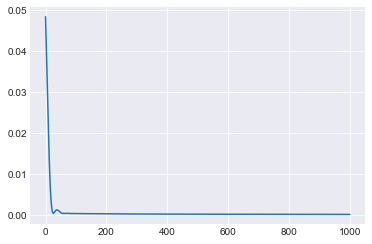

In [18]:
plt.plot(me_history.history['loss'])

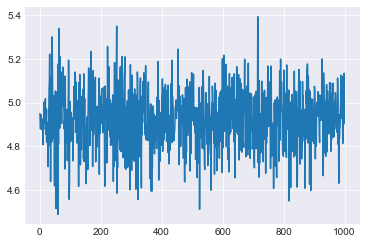

In [19]:
plt.plot(me_history.history['ref-error'])

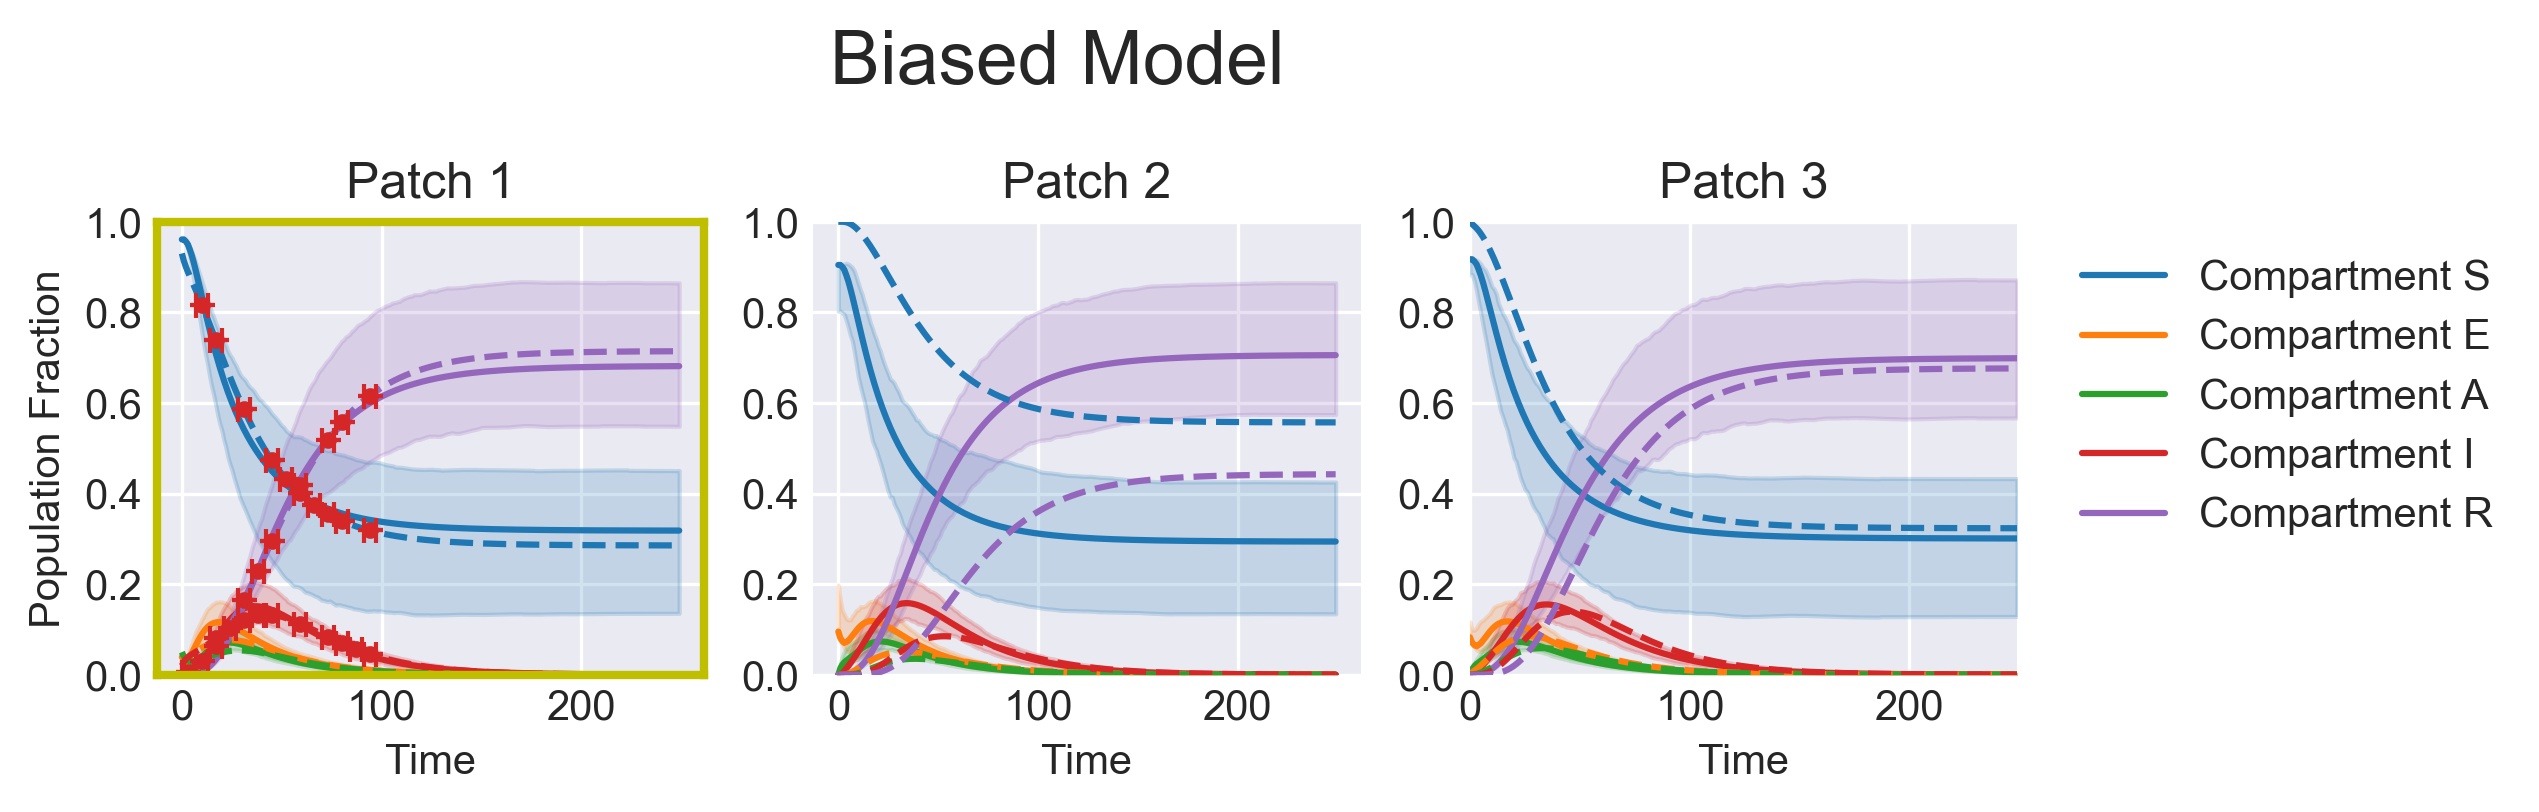

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Biased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,1,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,2,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Least squares regression

In [21]:
Tmtat = tmat.value
start = np.zeros((M, C))
start[0,0] = 0.05
# start[1,0] = 0.05
beta_start = 0.1
infect = maxentep.ContactInfectionLayer(beta_start, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, R_norm, Tmtat, infect, timesteps, agreement)

In [22]:
rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(timesteps)
regressed_traj = rmodel.get_traj()

250/250 [==============================] - 48s 191ms/step - loss: 0.0356 - output_2_loss: 0.0356


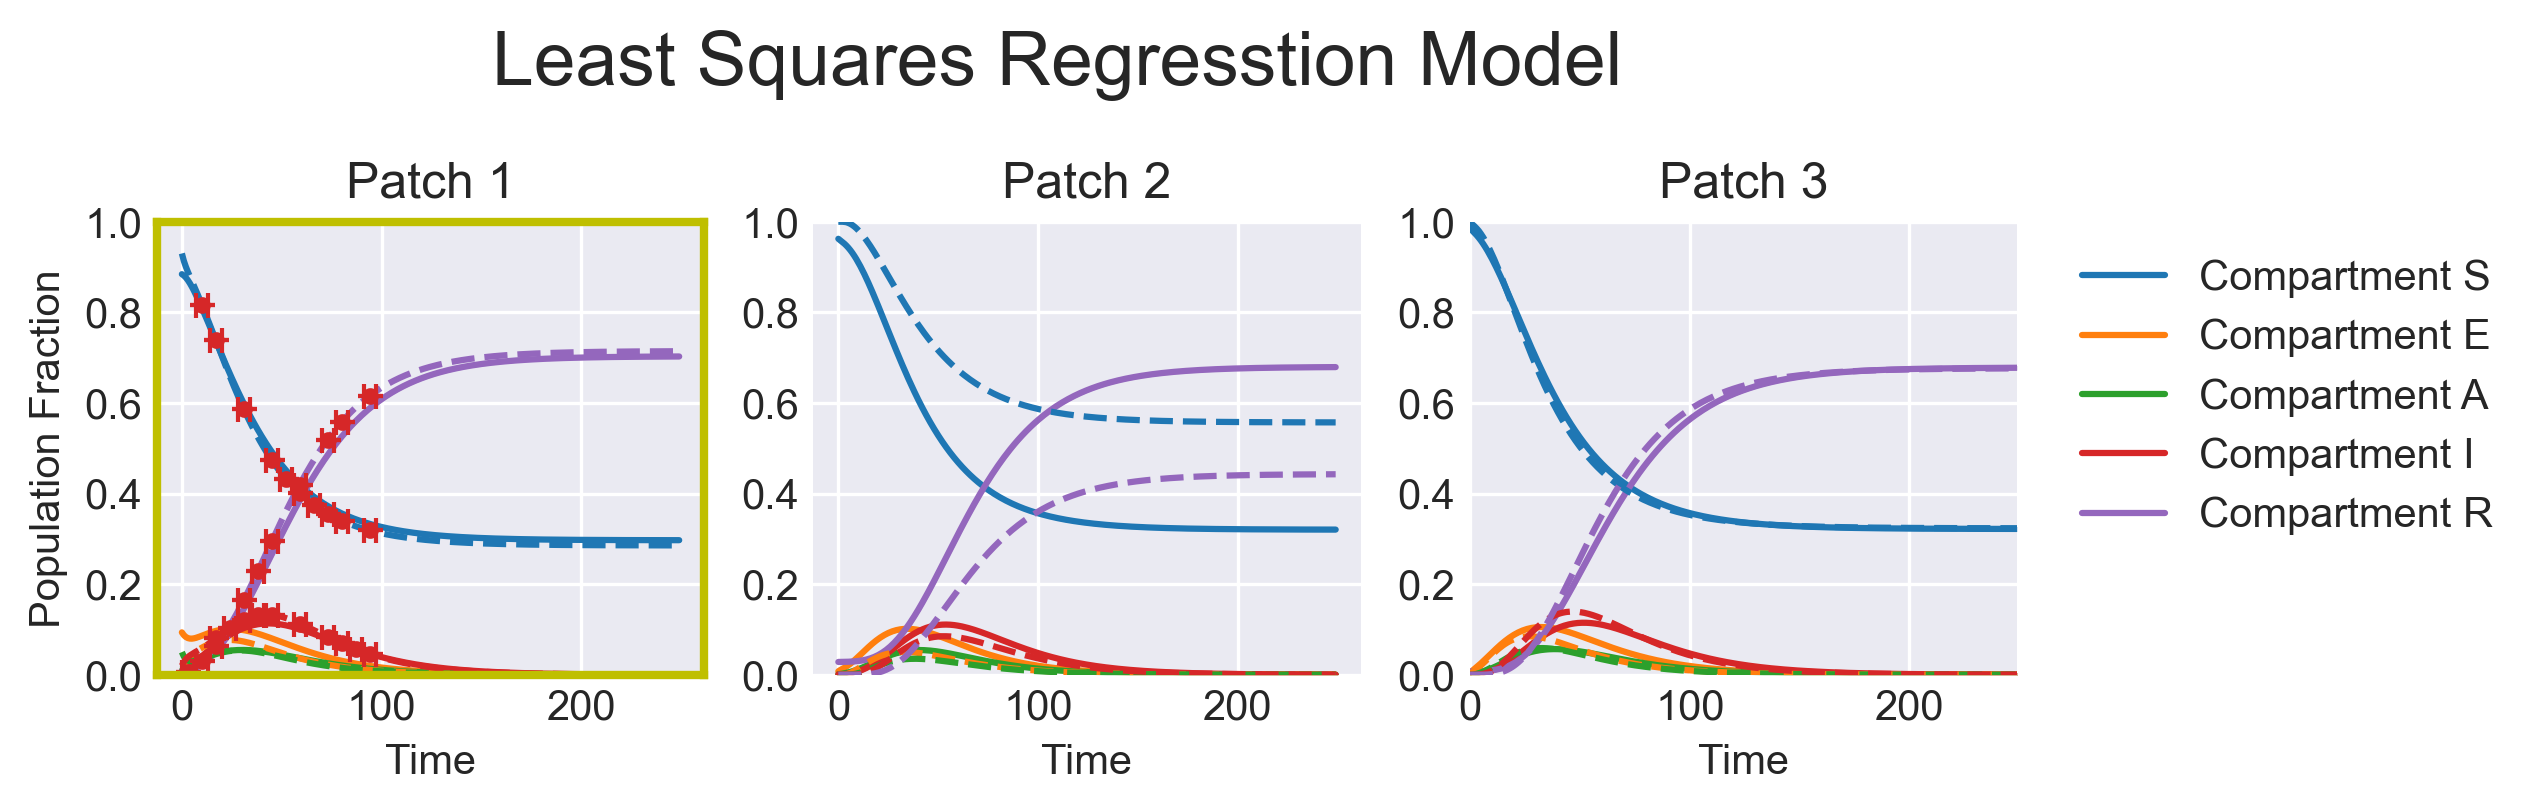

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Least Squares Regresstion Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(regressed_traj[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(regressed_traj[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(regressed_traj[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
#     axs[i].plot(regressed_traj[0,:,i,:])
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Hyper-biasing

In [24]:
fit_param_model = maxentep.MetaParameterJoint(np.zeros((M,)), R_norm , tmat, name='unbiased_model', hypers = hyper_pram)
fit_param_model.compile(tf.optimizers.SGD(1))
# fit_param_model.compile(tf.optimizers.Adam(0.1))

hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.SGD(learning_rate=1), 'mean_squared_error')

In [25]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=1, param_epochs=16, batch_size=64, epochs=1000)

Epoch 1/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0188 - weight-entropy: 3.4807
Epoch 2/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0063 - weight-entropy: 3.0518
Epoch 3/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0056 - weight-entropy: 2.9918
Epoch 4/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0053 - weight-entropy: 3.0367
Epoch 5/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0048 - weight-entropy: 3.0199
Epoch 6/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0058 - weight-entropy: 2.9759
Epoch 7/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0061 - weight-entropy: 3.0175
Epoch 8/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0047 - weight-entropy: 3.0025
Epoch 9/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0047 - weight-entropy: 2.9485
Epoch 10/1000
64/64 [=========================

64/64 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 2.8113
Epoch 72/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.8109
Epoch 73/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0040 - weight-entropy: 2.8233
Epoch 74/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 2.8287
Epoch 75/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0045 - weight-entropy: 2.8789
Epoch 76/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 2.7977
Epoch 77/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0039 - weight-entropy: 2.8123
Epoch 78/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 2.8309
Epoch 79/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 2.8042
Epoch 80/1000
64/64 [==============================

64/64 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 2.7970
Epoch 147/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0039 - weight-entropy: 2.7960
Epoch 148/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 2.7779
Epoch 149/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0042 - weight-entropy: 2.8148
Epoch 150/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0042 - weight-entropy: 2.8046
Epoch 151/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.8118
Epoch 152/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0032 - weight-entropy: 2.7809
Epoch 153/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.7875
Epoch 154/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0036 - weight-entropy: 2.7819
Epoch 155/1000
64/64 [=====================

Epoch 222/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 2.8154
Epoch 223/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0033 - weight-entropy: 2.7684
Epoch 224/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0034 - weight-entropy: 2.7764
Epoch 225/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 2.8188
Epoch 226/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 2.7759
Epoch 227/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 2.7677
Epoch 228/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0042 - weight-entropy: 2.8279
Epoch 229/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.7676
Epoch 230/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 2.8041
Epoch 231/1000
64/64 [======

64/64 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.7758
Epoch 298/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 2.7562
Epoch 299/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0033 - weight-entropy: 2.7840
Epoch 300/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 2.7508
Epoch 301/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0036 - weight-entropy: 2.7764
Epoch 302/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.7697
Epoch 303/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.7962
Epoch 304/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0032 - weight-entropy: 2.7916
Epoch 305/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0033 - weight-entropy: 2.7999
Epoch 306/1000
64/64 [=====================

Epoch 373/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.7300
Epoch 374/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0041 - weight-entropy: 2.7924
Epoch 375/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 2.7594
Epoch 376/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.7637
Epoch 377/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0039 - weight-entropy: 2.8006
Epoch 378/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.7916
Epoch 379/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 2.7652
Epoch 380/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 2.7753
Epoch 381/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 2.7327
Epoch 382/1000
64/64 [======

64/64 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 2.7746
Epoch 449/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 2.7586
Epoch 450/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0042 - weight-entropy: 2.7772
Epoch 451/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 2.7516
Epoch 452/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.7459
Epoch 453/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.7552
Epoch 454/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0040 - weight-entropy: 2.7859
Epoch 455/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.7458
Epoch 456/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 2.7435
Epoch 457/1000
64/64 [=====================

64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.7635
Epoch 524/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 2.7523
Epoch 525/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 2.7513
Epoch 526/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.7839
Epoch 527/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.7419
Epoch 528/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.7787
Epoch 529/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0034 - weight-entropy: 2.7447
Epoch 530/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.7540
Epoch 531/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 2.7574
Epoch 532/1000
64/64 [=====================

Epoch 599/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 2.7360
Epoch 600/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 2.7446
Epoch 601/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.7413
Epoch 602/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.7376
Epoch 603/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.7141
Epoch 604/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.7159
Epoch 605/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 2.7459
Epoch 606/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 2.7839
Epoch 607/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 2.7388
Epoch 608/1000
64/64 [======

64/64 [==============================] - 0s 1ms/step - loss: 0.0036 - weight-entropy: 2.7471
Epoch 675/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 2.7396
Epoch 676/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 2.7485
Epoch 677/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 2.7269
Epoch 678/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.7063
Epoch 679/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.7545
Epoch 680/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.7427
Epoch 681/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.7434
Epoch 682/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.7109
Epoch 683/1000
64/64 [=====================

Epoch 750/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 2.7271
Epoch 751/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0045 - weight-entropy: 2.7796
Epoch 752/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.6845
Epoch 753/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 2.7105
Epoch 754/1000
64/64 [==============================] - 0s 3ms/step - loss: 0.0027 - weight-entropy: 2.7033
Epoch 755/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.7285
Epoch 756/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.7455
Epoch 757/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 2.7592
Epoch 758/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.7137
Epoch 759/1000
64/64 [======

64/64 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 2.7310
Epoch 826/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 2.7138
Epoch 827/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.7085
Epoch 828/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 2.7116
Epoch 829/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.7349
Epoch 830/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.7630
Epoch 831/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0035 - weight-entropy: 2.7270
Epoch 832/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0035 - weight-entropy: 2.7441
Epoch 833/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0038 - weight-entropy: 2.7511
Epoch 834/1000
64/64 [=====================

64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.7197
Epoch 901/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 2.7082
Epoch 902/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 2.7575
Epoch 903/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.7142
Epoch 904/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.7409
Epoch 905/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.7218
Epoch 906/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 2.7200
Epoch 907/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 2.7176
Epoch 908/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 2.7091
Epoch 909/1000
64/64 [=====================

Epoch 976/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.7152
Epoch 977/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0041 - weight-entropy: 2.7156
Epoch 978/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 2.7375
Epoch 979/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.7463
Epoch 980/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 2.7119
Epoch 981/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0032 - weight-entropy: 2.7464
Epoch 982/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0036 - weight-entropy: 2.7512
Epoch 983/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 2.6968
Epoch 984/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0036 - weight-entropy: 2.7095
Epoch 985/1000
64/64 [======

In [26]:
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
# hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=64, epochs=200)

Epoch 1/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 2.7262
Epoch 2/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 2.6858
Epoch 3/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0046 - weight-entropy: 2.7743
Epoch 4/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - weight-entropy: 2.7383
Epoch 5/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - weight-entropy: 2.6311
Epoch 6/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 2.6241
Epoch 7/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.7465
Epoch 8/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 2.6446
Epoch 9/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0039 - weight-entropy: 2.5690
Epoch 10/200
16/16 [==============================] - 0

16/16 [==============================] - 0s 2ms/step - loss: 0.0045 - weight-entropy: 2.6401
Epoch 73/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0060 - weight-entropy: 2.6619
Epoch 74/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.6265
Epoch 75/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.6313
Epoch 76/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0039 - weight-entropy: 2.7049
Epoch 77/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 2.5981
Epoch 78/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 2.6032
Epoch 79/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0047 - weight-entropy: 2.7441
Epoch 80/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0041 - weight-entropy: 2.6059
Epoch 81/200
16/16 [==============================] - 0s 2m

16/16 [==============================] - 0s 3ms/step - loss: 0.0043 - weight-entropy: 2.6577
Epoch 149/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0025 - weight-entropy: 2.5864
Epoch 150/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0059 - weight-entropy: 2.6051
Epoch 151/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.5673
Epoch 152/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - weight-entropy: 2.6788
Epoch 153/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 2.5877
Epoch 154/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 2.5309
Epoch 155/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0060 - weight-entropy: 2.6587
Epoch 156/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 2.5337
Epoch 157/200
16/16 [==============================

32/32 [==============================] - 0s 10ms/step - loss: -0.0259 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -9.8925e-04 - beta-dist_loss: -0.0232
Epoch 14/200
32/32 [==============================] - 0s 9ms/step - loss: -0.0259 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -9.8988e-04 - beta-dist_loss: -0.0232
Epoch 15/200
32/32 [==============================] - 0s 12ms/step - loss: -0.0259 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -9.9045e-04 - beta-dist_loss: -0.0232
Epoch 16/200
32/32 [==============================] - 0s 9ms/step - loss: -0.0259 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -9.9107e-04 - beta-dist_loss: -0.0232
Epoch 17/200
32/32 [==============================] - 0s 9ms/step - loss: -0.0259 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -9.9166e-04 - beta-dist_loss: -0.0232
Epoch 18/200
32/32 [======

32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0234
Epoch 55/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0234
Epoch 56/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0234
Epoch 57/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0234
Epoch 58/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0234
Epoch 59/200
32/32 [=======================

32/32 [==============================] - 0s 10ms/step - loss: -0.0263 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 97/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0263 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 98/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0263 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 99/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0263 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 100/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0263 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 101/200
32/32 [=====================

32/32 [==============================] - 0s 10ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 139/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 140/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 141/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 142/200
32/32 [==============================] - 0s 9ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0235
Epoch 143/200
32/32 [===================

32/32 [==============================] - 0s 10ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0236
Epoch 181/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0236
Epoch 182/200
32/32 [==============================] - 0s 12ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0236
Epoch 183/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0236
Epoch 184/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0264 - R-dist-dist_loss: 0.0031 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0236
Epoch 185/200
32/32 [==================

16/16 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 2.6776
Epoch 40/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0060 - weight-entropy: 2.6373
Epoch 41/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0037 - weight-entropy: 2.6678
Epoch 42/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.7374
Epoch 43/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0039 - weight-entropy: 2.6764
Epoch 44/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0036 - weight-entropy: 2.6808
Epoch 45/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0036 - weight-entropy: 2.7439
Epoch 46/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - weight-entropy: 2.6206
Epoch 47/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0044 - weight-entropy: 2.6859
Epoch 48/200
16/16 [==============================] - 0s 1m

16/16 [==============================] - 0s 2ms/step - loss: 0.0039 - weight-entropy: 2.7523
Epoch 117/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 2.7307
Epoch 118/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 2.6955
Epoch 119/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - weight-entropy: 2.7460
Epoch 120/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0032 - weight-entropy: 2.7265
Epoch 121/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.6756
Epoch 122/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.6764
Epoch 123/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 2.7085
Epoch 124/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 2.6698
Epoch 125/200
16/16 [==============================

16/16 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 2.6702
Epoch 193/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.6918
Epoch 194/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 2.7402
Epoch 195/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0051 - weight-entropy: 2.7593
Epoch 196/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0040 - weight-entropy: 2.7105
Epoch 197/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.7161
Epoch 198/200
16/16 [==============================] - ETA: 0s - loss: 0.0033 - weight-entropy: 2.75 - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.7221
Epoch 199/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0041 - weight-entropy: 2.6920
Epoch 200/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0033 - weight-entropy: 2.7482
Epo

32/32 [==============================] - 0s 10ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 38/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 39/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 40/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 41/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 42/200
32/32 [=======================

32/32 [==============================] - 0s 10ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 80/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 81/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 82/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 83/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 84/200
32/32 [=======================

32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 122/200
32/32 [==============================] - 0s 12ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236 ETA: 0s - loss: -0.0251 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0044 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -
Epoch 123/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 124/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 125/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0262 - R-dist-dist_loss: 0

32/32 [==============================] - 0s 12ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 163/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 164/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 165/200
32/32 [==============================] - 0s 12ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 166/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0034 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 167/200
32/32 [==================

16/16 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 2.8137
Epoch 6/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.7944
Epoch 7/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0027 - weight-entropy: 2.8453
Epoch 8/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.8257
Epoch 9/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 2.7834
Epoch 10/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0052 - weight-entropy: 2.9233
Epoch 11/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 2.8639
Epoch 12/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 2.8221
Epoch 13/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 2.8011
Epoch 14/200
16/16 [==============================] - 0s 1ms/st

16/16 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 2.8723
Epoch 83/200
16/16 [==============================] - 0s 4ms/step - loss: 0.0037 - weight-entropy: 2.9156
Epoch 84/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 2.7927
Epoch 85/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 2.8714
Epoch 86/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 2.8460
Epoch 87/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 2.8760
Epoch 88/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 2.8768
Epoch 89/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 2.8762
Epoch 90/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 2.8941
Epoch 91/200
16/16 [==============================] - 0s 2m

16/16 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 2.8508
Epoch 159/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 2.8930
Epoch 160/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.8565
Epoch 161/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 2.9204
Epoch 162/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0026 - weight-entropy: 2.8995
Epoch 163/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.8834
Epoch 164/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 2.8299
Epoch 165/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 2.9022
Epoch 166/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0034 - weight-entropy: 2.9498
Epoch 167/200
16/16 [==============================

32/32 [==============================] - 0s 11ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 20/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 21/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 22/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 23/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 24/200
32/32 [=======================

32/32 [==============================] - 0s 11ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 62/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 63/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 64/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 65/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 66/200
32/32 [=======================

32/32 [==============================] - 0s 11ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 104/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 105/200
32/32 [==============================] - 0s 9ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 106/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 107/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 108/200
32/32 [===================

32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 145/200
32/32 [==============================] - 0s 12ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 146/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 147/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 148/200
32/32 [==============================] - 0s 12ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 149/200
32/32 [==================

32/32 [==============================] - 0s 11ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 187/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 188/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 189/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 190/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 191/200
32/32 [==================

16/16 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 3.1256
Epoch 51/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 3.0606
Epoch 52/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 3.0174
Epoch 53/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 3.1123
Epoch 54/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 3.1208
Epoch 55/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 3.0185
Epoch 56/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 3.0922
Epoch 57/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 3.0632
Epoch 58/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 3.1162
Epoch 59/200
16/16 [==============================] - 0s 3m

16/16 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 3.1368
Epoch 128/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 3.1261
Epoch 129/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 3.0667
Epoch 130/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 3.1283
Epoch 131/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 3.1137
Epoch 132/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 3.0941
Epoch 133/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.1082
Epoch 134/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 3.1818
Epoch 135/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.0186
Epoch 136/200
16/16 [==============================

32/32 [==============================] - 0s 10ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 3/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 4/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 5/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 6/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 7/200
32/32 [============================

32/32 [==============================] - 0s 10ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 45/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 46/200
32/32 [==============================] - 0s 12ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 47/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 48/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 49/200
32/32 [=======================

32/32 [==============================] - 0s 11ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 87/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 88/200
32/32 [==============================] - 0s 12ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 89/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 90/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0261 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 91/200
32/32 [=======================

32/32 [==============================] - 0s 11ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 129/200
32/32 [==============================] - 0s 12ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 130/200
32/32 [==============================] - 0s 10ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 131/200
32/32 [==============================] - 0s 11ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 132/200
32/32 [==============================] - 0s 12ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 133/200
32/32 [==================

32/32 [==============================] - 0s 12ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 169/200
32/32 [==============================] - 0s 13ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 170/200
32/32 [==============================] - 0s 13ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 171/200
32/32 [==============================] - 0s 12ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 172/200
32/32 [==============================] - 0s 12ms/step - loss: -0.0262 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0011 - beta-dist_loss: -0.0236
Epoch 173/200
32/32 [==================

64/64 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 3.1810
Epoch 17/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 3.2129
Epoch 18/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 3.1677
Epoch 19/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 3.2206
Epoch 20/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0040 - weight-entropy: 3.2220
Epoch 21/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 3.1883
Epoch 22/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 3.2129
Epoch 23/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 3.1600
Epoch 24/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 3.2017
Epoch 25/200
64/64 [==============================] - 0s 1m

64/64 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 3.1446
Epoch 94/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 3.1017
Epoch 95/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 3.0866
Epoch 96/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 3.1109
Epoch 97/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 3.1076
Epoch 98/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 3.0872
Epoch 99/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 3.1272
Epoch 100/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 3.1121
Epoch 101/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 3.1311
Epoch 102/200
64/64 [==============================] - 0s

64/64 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 3.1160
Epoch 170/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 3.0847
Epoch 171/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 3.1150
Epoch 172/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 3.1047
Epoch 173/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 3.0899
Epoch 174/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0023 - weight-entropy: 3.1140
Epoch 175/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 3.0777
Epoch 176/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 3.0858
Epoch 177/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 3.0663
Epoch 178/200
64/64 [==============================

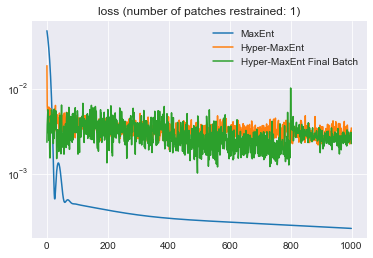

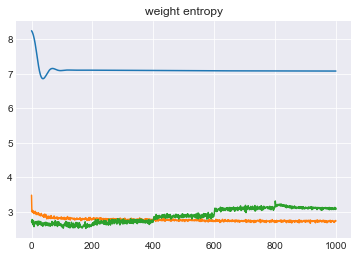

In [27]:
plt.plot(me_history.history['loss'],label='MaxEnt')
plt.plot(hme_history.history['loss'],label='Hyper-MaxEnt')
plt.plot(hme_final_history.history['loss'],label='Hyper-MaxEnt Final Batch')
plt.title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
plt.yscale('log')
plt.legend()
# plt.savefig('loss_{}_restraints'.format(len(restrained_patches)),dpi= 300)
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

# plt.plot(hme_history.history['prior-loss'])
# plt.title('neg log-likelihood')
# plt.show()

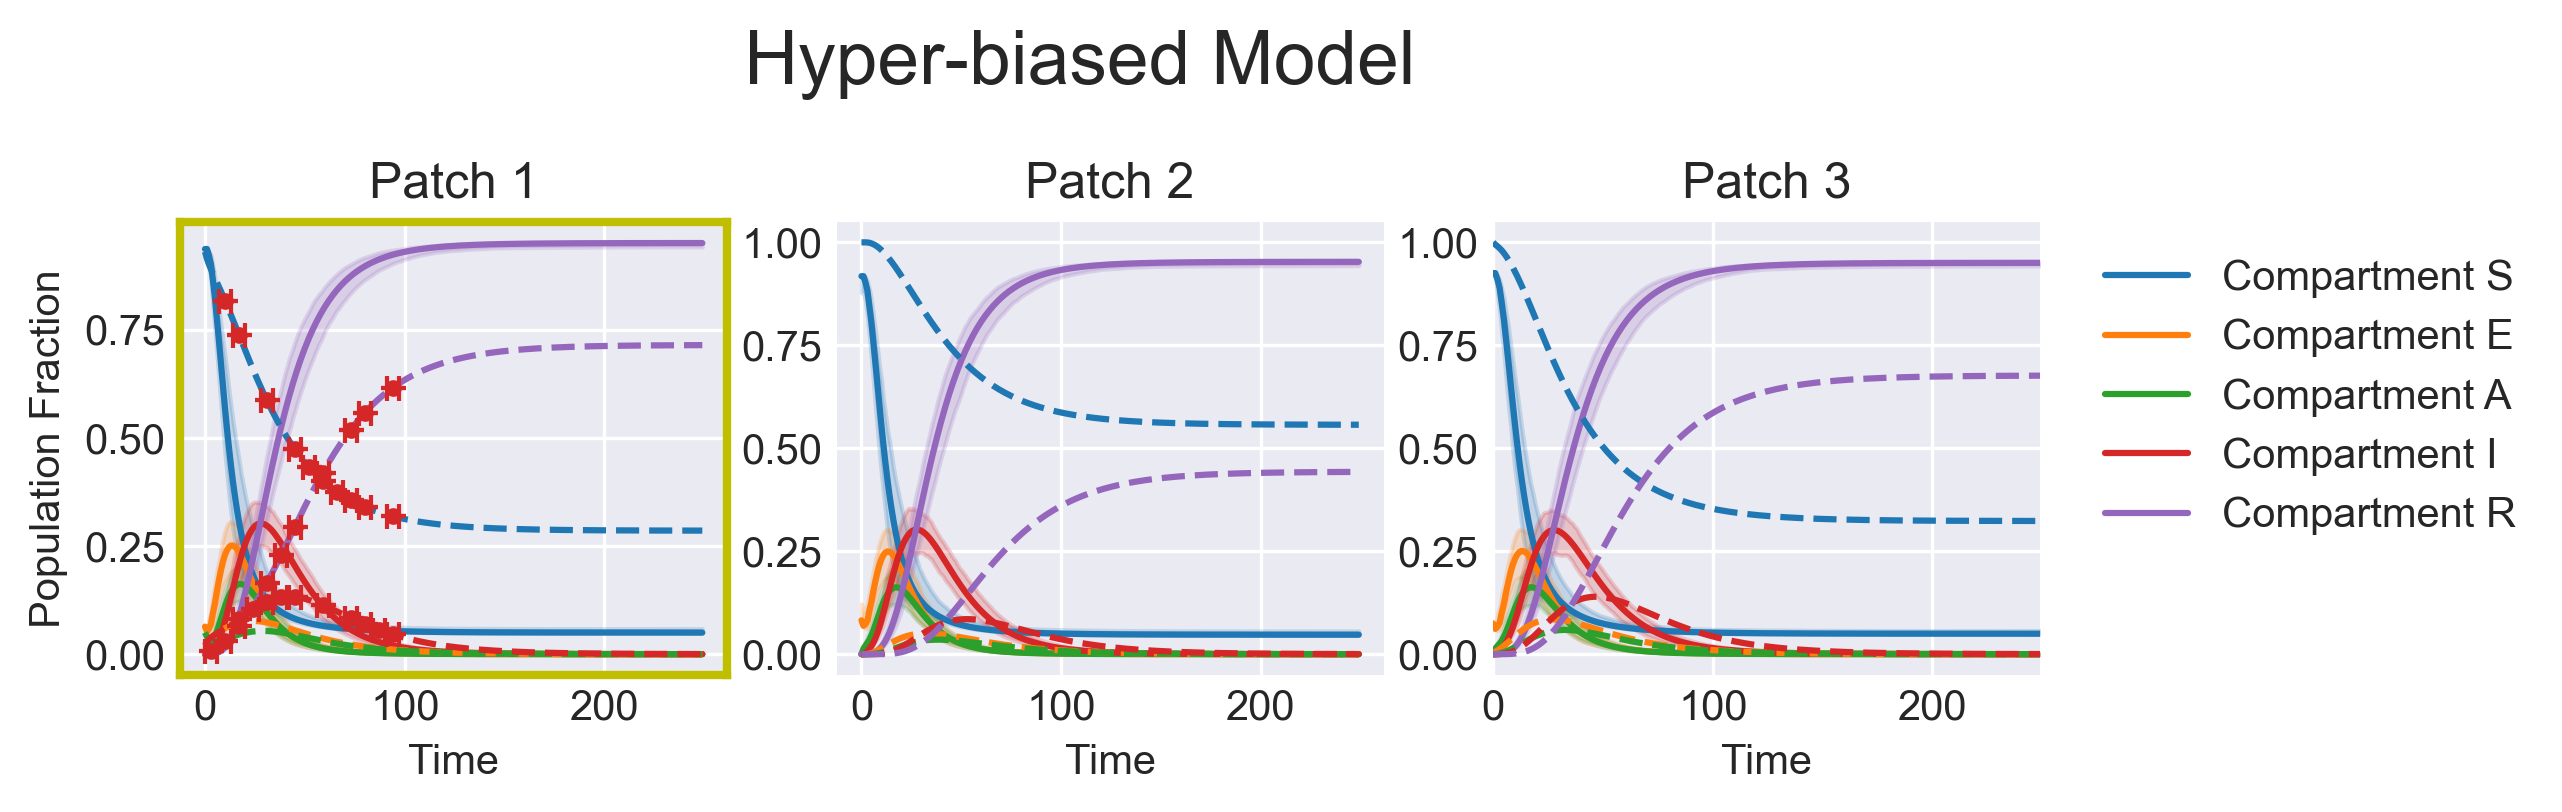

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Hyper-biased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,1,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,2,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1))
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()